In [95]:
#import packages

import pandas as pd
import twint
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
conda install jupyter_contrib_nbextensions && jupyter contrib nbextension install

## Get Tweet Data

Before we start to analyize the data, we need a collection of tweets. So let's use Twint to scrape Twitter for all tweets that mention Billie Eilish. She will be our pilot subject that we'll use to gather data on so that we can start getting insights on her audience. Let's gather all tweets from the last year with 'billie eilish' as our search keyword.

In [ ]:
#need a function to scrape twitter data


c = twint.Config()


c.Format = "ID {id} | Tweet {tweet}"
c.Search = 'billie eilish'
c.Lang = 'en'
c.Pandas_clean = True
c.Since = '2019-03-31'
c.Store_csv = True
c.Output = 'tweets.csv'
twint.run.Search(c)



## Data Cleaning

In [2]:
#lets read in the dataframe

df = pd.read_csv('tweets.csv')


In [3]:
#how many tweets did we get?

df.shape

(14396, 34)

In [4]:
#let's see if there's anything missing from our dataframe and see if we can get rid of anything

df.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              14394
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet                0
quote_url          13579
video                  0
near               14396
geo                14396
source             14396
user_rt_id         14396
user_rt            14396
retweet_id         14396
reply_to               0
retweet_date       14396
translate          14396
trans_src          14396
trans_dest         14396
dtype: int64

In [17]:
df.drop(['place', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 
        'trans_src', 'trans_dest'], inplace=True, axis=1)

### Preprocess Raw Text



In [79]:
#remove urls from tweets
def remove_links(tweet):

    result = re.sub(r"http\S+", "", tweet)
    result = re.sub(r"pic.twitter\S+", "", tweet)
    return result

In [82]:
df['tweet'] = df['tweet'].apply(lambda x: remove_links(x))

In [83]:
#remove numbers and stopwrds from tweets
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]

    # join the cleaned words in a list
    cleaned_word_list = " ".join(meaningful_words)

    return cleaned_word_list

In [85]:
df['clean_tweets'] = df['tweet'].apply(lambda x: preprocess(x))

In [86]:
#create another column where the words are lemmatized

lemmatizer = WordNetLemmatizer()

In [87]:
df['lemmatized_tweets'] = df['clean_tweets'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [88]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'video', 'reply_to', 'clean_tweets',
       'lemmatized_tweets'],
      dtype='object')

In [89]:
df.date.value_counts()



2020-03-30    7768
2020-03-31    4365
2020-04-01    2263
Name: date, dtype: int64

In [75]:
march_30_tweets =  df.loc[df.date == '2020-03-30']

In [90]:
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,tweet,...,retweets_count,likes_count,hashtags,cashtags,link,retweet,video,reply_to,clean_tweets,lemmatized_tweets
0,1245424152267325444,1245424152267325444,1585767231000,2020-04-01,14:53:51,Eastern Daylight Time,1080312985799802880,365mercy,365MercyReworks,#158: Rez Fail- when mercy tries to Rez and sh...,...,0,0,[],[],https://twitter.com/365Mercy/status/1245424152...,False,0,"[{'user_id': '1080312985799802880', 'username'...",rez fail mercy tries rez killed everything wan...,rez fail mercy try rez killed everything wante...
1,1245424109808320518,1244837980205973506,1585767221000,2020-04-01,14:53:41,Eastern Daylight Time,262983998,silveeah007,007,THIS! Has made my day! Gracias!!! 🥔🍠🍟,...,0,0,[],[],https://twitter.com/silveeah007/status/1245424...,False,0,"[{'user_id': '262983998', 'username': 'silveea...",made day gracias,made day gracias
2,1245424061997613056,1245424061997613056,1585767209000,2020-04-01,14:53:29,Eastern Daylight Time,1188077010817634307,vkookimochi,BTS⁷ ²⁰¹³🇦🇿🇹🇷,Billie Eilish & Khalid-lovely 🎧👌,...,0,0,[],[],https://twitter.com/vkookimochi/status/1245424...,False,0,"[{'user_id': '1188077010817634307', 'username'...",billie eilish khalid lovely,billie eilish khalid lovely
3,1245423906082697217,1245423906082697217,1585767172000,2020-04-01,14:52:52,Eastern Daylight Time,775521728910856192,celtra,Celtra,Do you guys an artist that you listen to and n...,...,0,1,[],[],https://twitter.com/Celtra/status/124542390608...,False,0,"[{'user_id': '775521728910856192', 'username':...",guys artist listen one would think would liste...,guy artist listen one would think would listen...
4,1245423842488655873,1245423517916631042,1585767157000,2020-04-01,14:52:37,Eastern Daylight Time,209775766,iamd_handycandy,Money Vs People,What the fuck is Billie Eilish,...,1,0,[],[],https://twitter.com/IamD_Handycandy/status/124...,False,0,"[{'user_id': '209775766', 'username': 'IamD_Ha...",fuck billie eilish,fuck billie eilish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,1244475710535688192,1244475710535688192,1585541105000,2020-03-30,00:05:05,Eastern Daylight Time,1244082575208886274,heathersebesty1,Heather Sebestyen,@billieeilish hi Billy heather from boise\nIda...,...,0,0,[],[],https://twitter.com/HeatherSebesty1/status/124...,False,0,"[{'user_id': '1244082575208886274', 'username'...",billieeilish hi billy heather boise idaho abso...,billieeilish hi billy heather boise idaho abso...
14392,1244475685965447173,1244475685965447173,1585541099000,2020-03-30,00:04:59,Eastern Daylight Time,861602371259908096,alvino2315,Alvino,"Billie Eilish , Khalid - lovely",...,0,1,[],[],https://twitter.com/Alvino2315/status/12444756...,False,1,"[{'user_id': '861602371259908096', 'username':...",billie eilish khalid lovely,billie eilish khalid lovely
14393,1244475605401219073,1244475605401219073,1585541080000,2020-03-30,00:04:40,Eastern Daylight Time,475577737,yayahhhhhhhhhh,.,WFH while listening to Billie Eilish is anothe...,...,0,0,[],[],https://twitter.com/yayahhhhhhhhhh/status/1244...,False,0,"[{'user_id': '475577737', 'username': 'yayahhh...",wfh listening billie eilish another level calm...,wfh listening billie eilish another level calm...
14394,1244475600615636997,1244358922334593024,1585541079000,2020-03-30,00:04:39,Eastern Daylight Time,1233466963172544512,fmaferlu,@Friends_maferlu,"Billie Eilish: Fool me once, fool me twice\nAr...",...,0,0,[],[],https://twitter.com/FMaferlu/status/1244475600...,False,0,"[{'user_id': '1233466963172544512', 'username'...",billie eilish fool fool twice death paradise n...,billie eilish fool fool twice death paradise n...


### Save Cleaned data

In [100]:
clean_df = df.to_csv('clean_billie_tweets.csv')

## EDA

### Open clean dataframe

In [104]:
clean_df = pd.read_csv('clean_billie_tweets.csv', index_col=0)


In [105]:
#let's explore the distribution of tweets by date

tweets_by_date = clean_df.groupby('date')['tweet'].count().reset_index()

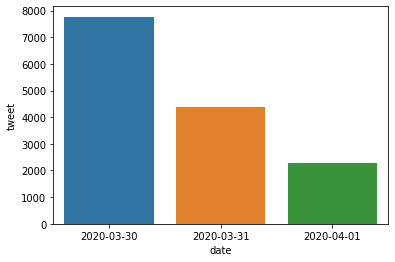

In [106]:
sns.barplot(data=tweets_by_date, x='date', y='tweet')